In [1]:
import keras
from keras import layers
from keras.layers import LSTM, Dense, LSTM, Conv2D
from keras.layers import Dense
from keras import *
from keras import backend as K
import pandas as pd
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

model = keras.Sequential()
model.add(keras.layers.Conv1D(128, (2), strides=(1),padding = 'same',  data_format= 'channels_last', activation='relu', 
                              input_shape=(1000, 62)))  ### output [?,1000,128]

model.add(keras.layers.Conv1D(256, (2), strides=(1), padding = 'same', activation = 'relu'))  ### layer2 output 1000*256
model.add(keras.layers.Conv1D(512, (2), strides=(1), padding='same', activation='relu'))   ### layer3  output 1000* 512
# model.add(keras.layers.Conv1D(1024, (2), strides=(1), padding='same', activation='relu'))  ## layer4 output 1000*1024
model.add(keras.layers.Dense(192, activation='relu'))
model.add(keras.layers.Dropout(0.5))

model.add(LSTM(192, return_sequences = True, input_shape = (192, 1)))
model.add(LSTM(192))  # returns a sequence of vectors of dimension 32
model.add(Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(Dense(15, activation='softmax'))


# SGD= keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.1, nesterov=True)
Adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.000001, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer= 'Adam',
              metrics=['accuracy'])
model.summary()

Using TensorFlow backend.
W0820 21:10:24.660080 140262195578624 deprecation_wrapper.py:119] From /home/ydwang/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0820 21:10:24.670710 140262195578624 deprecation_wrapper.py:119] From /home/ydwang/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0820 21:10:24.673075 140262195578624 deprecation_wrapper.py:119] From /home/ydwang/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0820 21:10:24.718184 140262195578624 deprecation_wrapper.py:119] From /home/ydwang/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1000, 128)         16000     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1000, 256)         65792     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1000, 512)         262656    
_________________________________________________________________
dense_1 (Dense)              (None, 1000, 192)         98496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000, 192)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1000, 192)         295680    
_________________________________________________________________
lstm_2 (LSTM)                (None, 192)               295680    
__________

In [2]:
def pred_approx_val(arr, treshold):
    array_np = np.copy(arr)
    low_val_indices = arr < treshold
    high_val_indices = arr >= treshold
    array_np[low_val_indices] = 0
    array_np[high_val_indices] = 1
    return array_np


def perf_measure(actual, score, treshold):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    size = len(score)
    for i in range(size):
        predArr = pred_approx_val(score[i], treshold)
        for j in range(len(score[i])):
            if(predArr[j] != actual[i][j] and predArr[j] == 1):
                FP+=1
            if(predArr[j] == actual[i][j] == 1):
                TP+=1
            if(predArr[j] != actual[i][j] and predArr[j] == 0):
                FN+=1
            if(predArr[j] == actual[i][j] == 0):
                TN+=1
    return TP, FP, TN, FN


def plot_far_frr(far, frr, n):

    axisVal = np.arange(0, 1.0, 0.01)
    n = str(n)
    # PLOT FAR FRR
    plt.figure()
    lw = 2
    plt.plot(far, axisVal, label='False Accept Rate', color='blue', lw=lw)
    plt.plot(axisVal, frr, label='False Reject Rate', color='red', lw=lw)
    plt.xlim([0.0, 1.250])
    plt.ylim([0.0, 1.250])
    plt.xlabel('Treshold')
    plt.ylabel('Errors')
    plt.title('FAR and FRR')
    plt.legend(loc="lower right")
    plt.show()
    plt.savefig('./1D-images/test'+ n +'.jpg')

def plot_far_frr2(far, frr, n):
    # PLOT FAR FRR

    ss = 1 - np.array(frr)
    ss = ss.tolist()
    n = str(n)
    plt.figure()
    lw = 2
    plt.plot(far, ss, label='False Accept Rate', color='blue', lw=lw)
    plt.xlim([0.0, 1.250])
    plt.ylim([0.0, 1.250])
    plt.xlabel('far')
    plt.ylabel('1-frr')
    plt.title('FAR and FRR')
    plt.legend(loc="lower right")
    plt.show()
    plt.savefig('./1D-images/test2' + n + '.jpg')

    
def prepare_graph_far_frr(actual, score, totalP, totalN):
    step = 1
    far = []   ######为什么要弄成词典？
    frr = []   ###而不是list？

    for i in range(0, 100, step):
        _, FP, _, FN = perf_measure(actual, score, i/float(100))
        a, b = calc_far_frr(FP, FN, totalP, totalN)
        far.append(a)
        frr.append(b)
    return far, frr

def calc_far_frr(FP, FN, totalP, totalN):
    FAR = FP/float(totalP) # False Accept Rate in percentage
    FRR = FN/float(totalN) # False Reject Rate in percentage
    return FAR, FRR

(3495000, 62)
Y.shape (3495, 15)
folder:  0


W0820 21:10:26.966474 140262195578624 deprecation.py:323] From /home/ydwang/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


training examples: 3146
test examples    : 349
Epoch 1/100
3146/3146 [==============================] - 65s 21ms/step - loss: 2.6819 - acc: 0.0772
Epoch 2/100
3146/3146 [==============================] - 61s 19ms/step - loss: 2.5693 - acc: 0.1173
Epoch 3/100
3146/3146 [==============================] - 61s 19ms/step - loss: 2.3623 - acc: 0.1716
Epoch 4/100
3146/3146 [==============================] - 61s 19ms/step - loss: 2.2303 - acc: 0.2028
Epoch 5/100
3146/3146 [==============================] - 61s 19ms/step - loss: 2.0408 - acc: 0.2416
Epoch 6/100
3146/3146 [==============================] - 61s 19ms/step - loss: 2.4559 - acc: 0.2031
Epoch 7/100
3146/3146 [==============================] - 60s 19ms/step - loss: 2.3853 - acc: 0.1602
Epoch 8/100
3146/3146 [==============================] - 60s 19ms/step - loss: 2.2549 - acc: 0.2006
Epoch 9/100
3146/3146 [==============================] - 60s 19ms/step - loss: 2.1629 - acc: 0.2044
Epoch 10/100
3146/3146 [=============================

3146/3146 [==============================] - 59s 19ms/step - loss: 0.9373 - acc: 0.6545
Epoch 82/100
3146/3146 [==============================] - 59s 19ms/step - loss: 0.8309 - acc: 0.6917
Epoch 83/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.7449 - acc: 0.7228
Epoch 84/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.8217 - acc: 0.7012
Epoch 85/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.8148 - acc: 0.7107
Epoch 86/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.9581 - acc: 0.6507
Epoch 87/100
3146/3146 [==============================] - 60s 19ms/step - loss: 1.0646 - acc: 0.5995
Epoch 88/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.9158 - acc: 0.6675
Epoch 89/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.8184 - acc: 0.7025
Epoch 90/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.7528 - acc: 0.7282
Epo

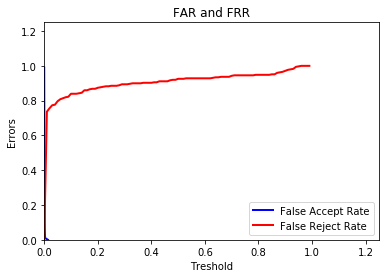

<Figure size 432x288 with 0 Axes>

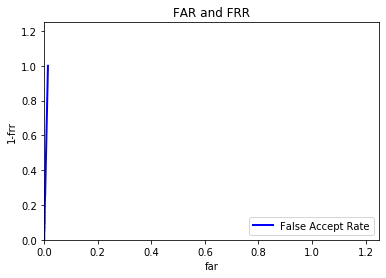

<Figure size 432x288 with 0 Axes>

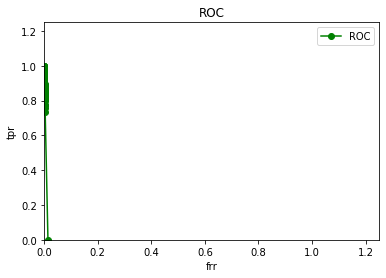

folder:  1
training examples: 3146
test examples    : 349
Epoch 1/100
3146/3146 [==============================] - 60s 19ms/step - loss: 1.7372 - acc: 0.6949
Epoch 2/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.9277 - acc: 0.7041
Epoch 3/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.6691 - acc: 0.7804
Epoch 4/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.5888 - acc: 0.7956
Epoch 5/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.5009 - acc: 0.8318
Epoch 6/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.4306 - acc: 0.8535
Epoch 7/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.5581 - acc: 0.8077
Epoch 8/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.4711 - acc: 0.8306
Epoch 9/100
3146/3146 [==============================] - 59s 19ms/step - loss: 0.4165 - acc: 0.8554
Epoch 10/100
3146/3146 [==================

3146/3146 [==============================] - 60s 19ms/step - loss: 0.0952 - acc: 0.9720
Epoch 82/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0801 - acc: 0.9819
Epoch 83/100
3146/3146 [==============================] - 59s 19ms/step - loss: 0.0804 - acc: 0.9781
Epoch 84/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0680 - acc: 0.9809
Epoch 85/100
3146/3146 [==============================] - 59s 19ms/step - loss: 0.0639 - acc: 0.9819
Epoch 86/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0494 - acc: 0.9889
Epoch 87/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0434 - acc: 0.9914
Epoch 88/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0454 - acc: 0.9895
Epoch 89/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0381 - acc: 0.9905
Epoch 90/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0596 - acc: 0.9857
Epo

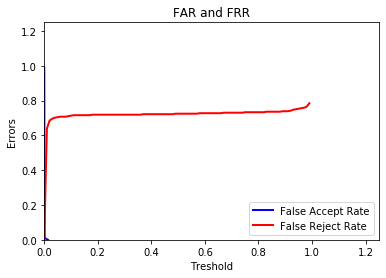

<Figure size 432x288 with 0 Axes>

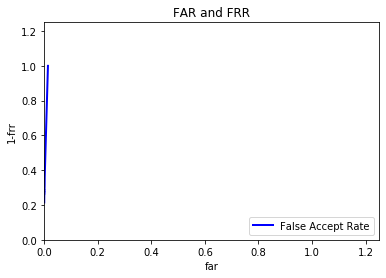

<Figure size 432x288 with 0 Axes>

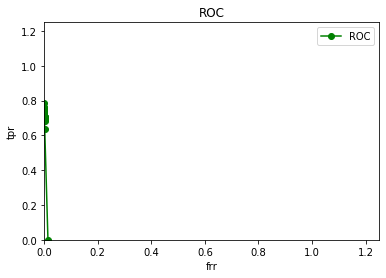

folder:  2
training examples: 3146
test examples    : 349
Epoch 1/100
3146/3146 [==============================] - 61s 19ms/step - loss: 0.6592 - acc: 0.8678
Epoch 2/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.3344 - acc: 0.8989
Epoch 3/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.2358 - acc: 0.9269
Epoch 4/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.2458 - acc: 0.9275
Epoch 5/100
3146/3146 [==============================] - 59s 19ms/step - loss: 0.2124 - acc: 0.9304
Epoch 6/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.1442 - acc: 0.9536
Epoch 7/100
3146/3146 [==============================] - 59s 19ms/step - loss: 0.1237 - acc: 0.9587
Epoch 8/100
3146/3146 [==============================] - 59s 19ms/step - loss: 0.1197 - acc: 0.9660
Epoch 9/100
3146/3146 [==============================] - 59s 19ms/step - loss: 0.1022 - acc: 0.9673
Epoch 10/100
3146/3146 [==================

3146/3146 [==============================] - 60s 19ms/step - loss: 0.0048 - acc: 0.9990
Epoch 82/100
3146/3146 [==============================] - 59s 19ms/step - loss: 0.0050 - acc: 0.9994
Epoch 83/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0109 - acc: 0.9975
Epoch 84/100
3146/3146 [==============================] - 59s 19ms/step - loss: 0.0104 - acc: 0.9971
Epoch 85/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0073 - acc: 0.9990
Epoch 86/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0045 - acc: 0.9990
Epoch 87/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0048 - acc: 0.9994
Epoch 88/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0103 - acc: 0.9975
Epoch 89/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0298 - acc: 0.9943
Epoch 90/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0466 - acc: 0.9847
Epo

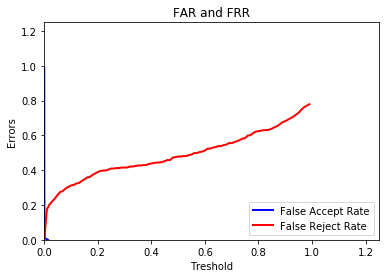

<Figure size 432x288 with 0 Axes>

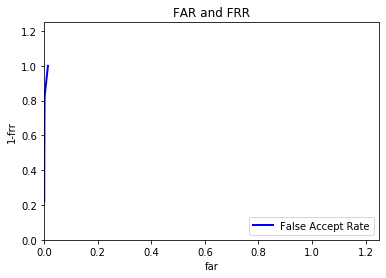

<Figure size 432x288 with 0 Axes>

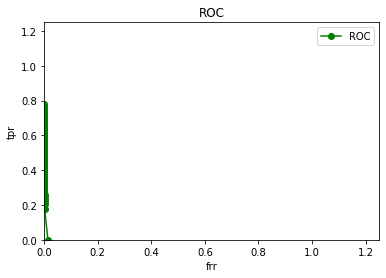

folder:  3
training examples: 3146
test examples    : 349
Epoch 1/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.1675 - acc: 0.9612
Epoch 2/100
3146/3146 [==============================] - 59s 19ms/step - loss: 0.2569 - acc: 0.9243
Epoch 3/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.1350 - acc: 0.9609
Epoch 4/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.1135 - acc: 0.9666
Epoch 5/100
3146/3146 [==============================] - 59s 19ms/step - loss: 0.0682 - acc: 0.9822
Epoch 6/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0868 - acc: 0.9765
Epoch 7/100
3146/3146 [==============================] - 59s 19ms/step - loss: 0.0735 - acc: 0.9784
Epoch 8/100
3146/3146 [==============================] - 59s 19ms/step - loss: 0.0734 - acc: 0.9803
Epoch 9/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0611 - acc: 0.9832
Epoch 10/100
3146/3146 [==================

3146/3146 [==============================] - 60s 19ms/step - loss: 0.0096 - acc: 0.9965
Epoch 82/100
3146/3146 [==============================] - 59s 19ms/step - loss: 0.0090 - acc: 0.9978
Epoch 83/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0026 - acc: 1.0000
Epoch 84/100
3146/3146 [==============================] - 59s 19ms/step - loss: 0.0047 - acc: 0.9984
Epoch 85/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0030 - acc: 0.9994
Epoch 86/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0029 - acc: 0.9997
Epoch 87/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0023 - acc: 0.9997
Epoch 88/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0017 - acc: 1.0000
Epoch 89/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0018 - acc: 0.9997
Epoch 90/100
3146/3146 [==============================] - 59s 19ms/step - loss: 0.0016 - acc: 1.0000
Epo

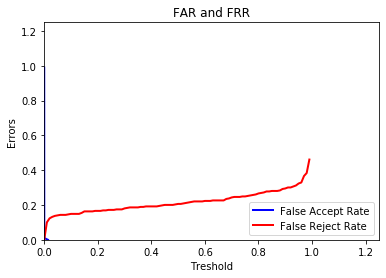

<Figure size 432x288 with 0 Axes>

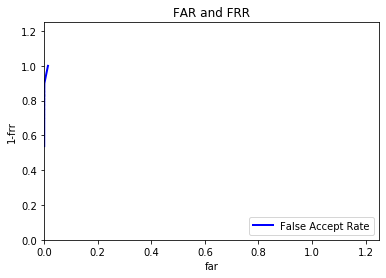

<Figure size 432x288 with 0 Axes>

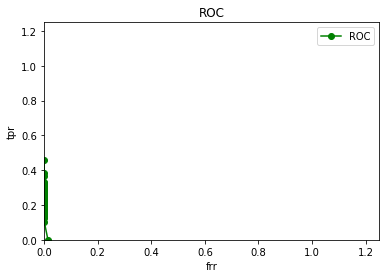

folder:  4
training examples: 3146
test examples    : 349
Epoch 1/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0670 - acc: 0.9828
Epoch 2/100
3146/3146 [==============================] - 59s 19ms/step - loss: 0.5962 - acc: 0.9180
Epoch 3/100
3146/3146 [==============================] - 59s 19ms/step - loss: 1.3841 - acc: 0.6745
Epoch 4/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.7043 - acc: 0.8013
Epoch 5/100
3146/3146 [==============================] - 59s 19ms/step - loss: 0.3790 - acc: 0.8887
Epoch 6/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.2502 - acc: 0.9269
Epoch 7/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.1730 - acc: 0.9447
Epoch 8/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.1370 - acc: 0.9584
Epoch 9/100
3146/3146 [==============================] - 59s 19ms/step - loss: 0.0774 - acc: 0.9800
Epoch 10/100
3146/3146 [==================

3146/3146 [==============================] - 60s 19ms/step - loss: 0.0570 - acc: 0.9803
Epoch 82/100
3146/3146 [==============================] - 59s 19ms/step - loss: 0.0693 - acc: 0.9806
Epoch 83/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0836 - acc: 0.9749
Epoch 84/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0564 - acc: 0.9841
Epoch 85/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0245 - acc: 0.9924
Epoch 86/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0158 - acc: 0.9959
Epoch 87/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0138 - acc: 0.9965
Epoch 88/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0160 - acc: 0.9952
Epoch 89/100
3146/3146 [==============================] - 59s 19ms/step - loss: 0.0140 - acc: 0.9971
Epoch 90/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0143 - acc: 0.9971
Epo

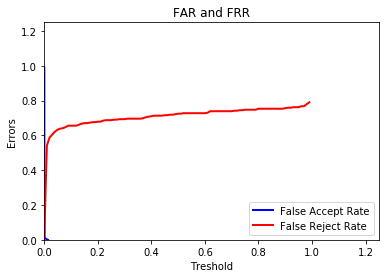

<Figure size 432x288 with 0 Axes>

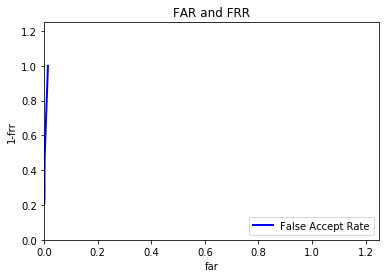

<Figure size 432x288 with 0 Axes>

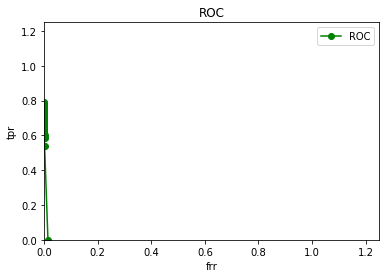

folder:  5
training examples: 3146
test examples    : 349
Epoch 1/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.1902 - acc: 0.9555
Epoch 2/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0595 - acc: 0.9816
Epoch 3/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0409 - acc: 0.9873
Epoch 4/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0300 - acc: 0.9921
Epoch 5/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0288 - acc: 0.9930
Epoch 6/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0221 - acc: 0.9940
Epoch 7/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0157 - acc: 0.9952
Epoch 8/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0120 - acc: 0.9975
Epoch 9/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0072 - acc: 0.9984
Epoch 10/100
3146/3146 [==================

3146/3146 [==============================] - 59s 19ms/step - loss: 0.0077 - acc: 0.9978
Epoch 82/100
3146/3146 [==============================] - 57s 18ms/step - loss: 0.0060 - acc: 0.9984
Epoch 83/100
3146/3146 [==============================] - 59s 19ms/step - loss: 0.0035 - acc: 0.9994
Epoch 84/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0066 - acc: 0.9990
Epoch 85/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0066 - acc: 0.9987
Epoch 86/100
3146/3146 [==============================] - 59s 19ms/step - loss: 0.0152 - acc: 0.9959
Epoch 87/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0077 - acc: 0.9981
Epoch 88/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0049 - acc: 0.9987
Epoch 89/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0034 - acc: 0.9994
Epoch 90/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0028 - acc: 0.9994
Epo

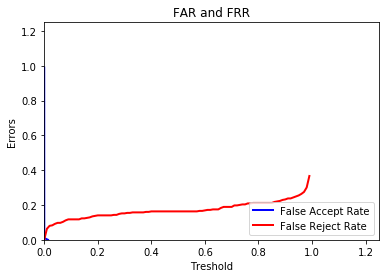

<Figure size 432x288 with 0 Axes>

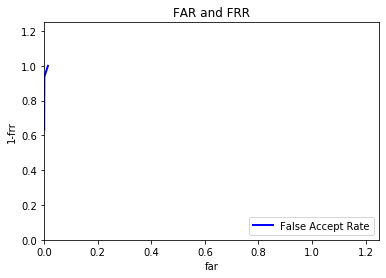

<Figure size 432x288 with 0 Axes>

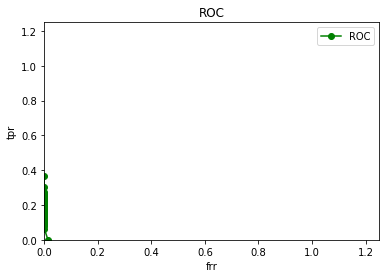

folder:  6
training examples: 3146
test examples    : 349
Epoch 1/100
3146/3146 [==============================] - 59s 19ms/step - loss: 0.0696 - acc: 0.9844
Epoch 2/100
3146/3146 [==============================] - 59s 19ms/step - loss: 0.0359 - acc: 0.9889
Epoch 3/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0390 - acc: 0.9901
Epoch 4/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0400 - acc: 0.9889
Epoch 5/100
3146/3146 [==============================] - 59s 19ms/step - loss: 0.0509 - acc: 0.9838
Epoch 6/100
3146/3146 [==============================] - 59s 19ms/step - loss: 0.0270 - acc: 0.9914
Epoch 7/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0199 - acc: 0.9936
Epoch 8/100
3146/3146 [==============================] - 59s 19ms/step - loss: 0.0221 - acc: 0.9949
Epoch 9/100
3146/3146 [==============================] - 59s 19ms/step - loss: 0.0283 - acc: 0.9930
Epoch 10/100
3146/3146 [==================

3146/3146 [==============================] - 59s 19ms/step - loss: 0.0097 - acc: 0.9968
Epoch 82/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0057 - acc: 0.9981
Epoch 83/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0041 - acc: 0.9990
Epoch 84/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0063 - acc: 0.9978
Epoch 85/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0035 - acc: 0.9994
Epoch 86/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0051 - acc: 0.9987
Epoch 87/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0095 - acc: 0.9975
Epoch 88/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0175 - acc: 0.9959
Epoch 89/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0356 - acc: 0.9914
Epoch 90/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0235 - acc: 0.9936
Epo

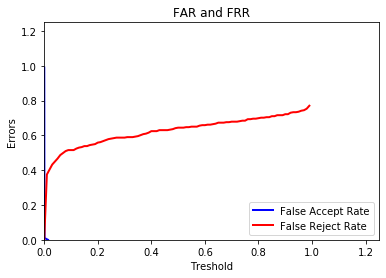

<Figure size 432x288 with 0 Axes>

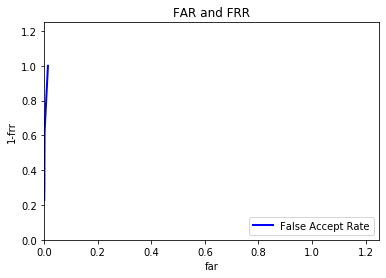

<Figure size 432x288 with 0 Axes>

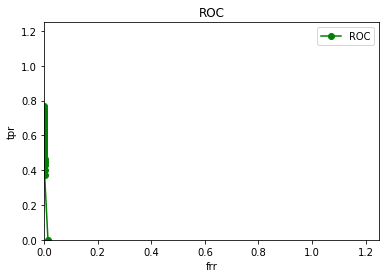

folder:  7
training examples: 3146
test examples    : 349
Epoch 1/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.1810 - acc: 0.9622
Epoch 2/100
3146/3146 [==============================] - 59s 19ms/step - loss: 0.0813 - acc: 0.9793
Epoch 3/100
3146/3146 [==============================] - 59s 19ms/step - loss: 0.0715 - acc: 0.9806
Epoch 4/100
3146/3146 [==============================] - 59s 19ms/step - loss: 0.0385 - acc: 0.9905
Epoch 5/100
3146/3146 [==============================] - 59s 19ms/step - loss: 0.0380 - acc: 0.9882
Epoch 6/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0257 - acc: 0.9936
Epoch 7/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0211 - acc: 0.9936
Epoch 8/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0305 - acc: 0.9927
Epoch 9/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0218 - acc: 0.9930
Epoch 10/100
3146/3146 [==================

3146/3146 [==============================] - 60s 19ms/step - loss: 0.1047 - acc: 0.9692
Epoch 82/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.1981 - acc: 0.9374
Epoch 83/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.1019 - acc: 0.9736
Epoch 84/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0504 - acc: 0.9841
Epoch 85/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0385 - acc: 0.9892
Epoch 86/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0286 - acc: 0.9908
Epoch 87/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0357 - acc: 0.9886
Epoch 88/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0899 - acc: 0.9727
Epoch 89/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0388 - acc: 0.9914
Epoch 90/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0332 - acc: 0.9905
Epo

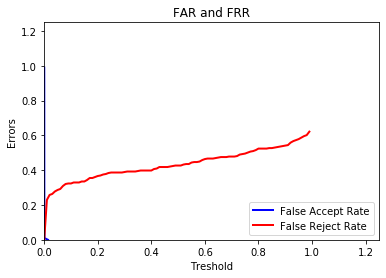

<Figure size 432x288 with 0 Axes>

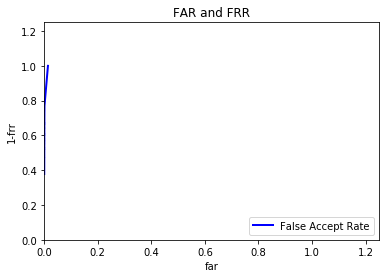

<Figure size 432x288 with 0 Axes>

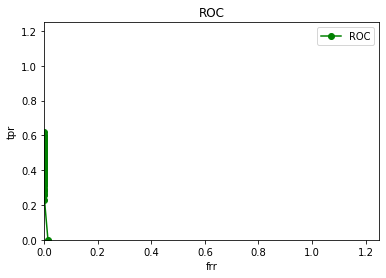

folder:  8
training examples: 3146
test examples    : 349
Epoch 1/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.1213 - acc: 0.9733
Epoch 2/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0619 - acc: 0.9790
Epoch 3/100
3146/3146 [==============================] - 59s 19ms/step - loss: 0.0420 - acc: 0.9879
Epoch 4/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0326 - acc: 0.9898
Epoch 5/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0152 - acc: 0.9959
Epoch 6/100
3146/3146 [==============================] - 59s 19ms/step - loss: 0.0108 - acc: 0.9968
Epoch 7/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0114 - acc: 0.9975
Epoch 8/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0077 - acc: 0.9984
Epoch 9/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0069 - acc: 0.9978
Epoch 10/100
3146/3146 [==================

3146/3146 [==============================] - 60s 19ms/step - loss: 0.0055 - acc: 0.9994
Epoch 82/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0040 - acc: 0.9987
Epoch 83/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0076 - acc: 0.9971
Epoch 84/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0034 - acc: 0.9990
Epoch 85/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0033 - acc: 0.9987
Epoch 86/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0045 - acc: 0.9990
Epoch 87/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0042 - acc: 0.9978
Epoch 88/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0045 - acc: 0.9987
Epoch 89/100
3146/3146 [==============================] - 59s 19ms/step - loss: 0.0021 - acc: 0.9997
Epoch 90/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0030 - acc: 0.9987
Epo

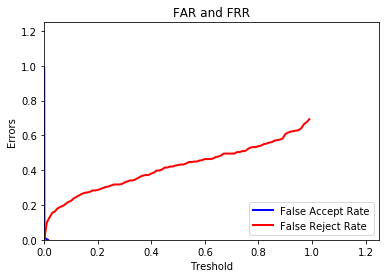

<Figure size 432x288 with 0 Axes>

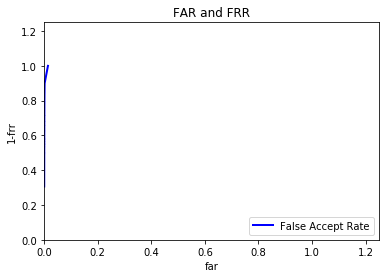

<Figure size 432x288 with 0 Axes>

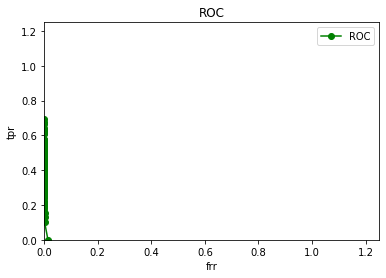

folder:  9
training examples: 3146
test examples    : 349
Epoch 1/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0939 - acc: 0.9739
Epoch 2/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0312 - acc: 0.9905
Epoch 3/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0209 - acc: 0.9927
Epoch 4/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0148 - acc: 0.9955
Epoch 5/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0080 - acc: 0.9987
Epoch 6/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0063 - acc: 0.9987
Epoch 7/100
3146/3146 [==============================] - 59s 19ms/step - loss: 0.0067 - acc: 0.9987
Epoch 8/100
3146/3146 [==============================] - 60s 19ms/step - loss: 0.0053 - acc: 0.9984
Epoch 9/100
3146/3146 [==============================] - 59s 19ms/step - loss: 0.0123 - acc: 0.9965
Epoch 10/100
3146/3146 [==================

3146/3146 [==============================] - 64s 20ms/step - loss: 0.0500 - acc: 0.9844
Epoch 82/100
3146/3146 [==============================] - 63s 20ms/step - loss: 0.0392 - acc: 0.9905
Epoch 83/100
3146/3146 [==============================] - 65s 21ms/step - loss: 0.0248 - acc: 0.9933
Epoch 84/100
3146/3146 [==============================] - 65s 21ms/step - loss: 0.0216 - acc: 0.9952
Epoch 85/100
3146/3146 [==============================] - 65s 21ms/step - loss: 0.0181 - acc: 0.9946
Epoch 86/100
3146/3146 [==============================] - 64s 20ms/step - loss: 0.0132 - acc: 0.9965
Epoch 87/100
3146/3146 [==============================] - 63s 20ms/step - loss: 0.0096 - acc: 0.9975
Epoch 88/100
3146/3146 [==============================] - 65s 21ms/step - loss: 0.0119 - acc: 0.9968
Epoch 89/100
3146/3146 [==============================] - 65s 21ms/step - loss: 0.0104 - acc: 0.9975
Epoch 90/100
3146/3146 [==============================] - 65s 21ms/step - loss: 0.0067 - acc: 0.9987
Epo

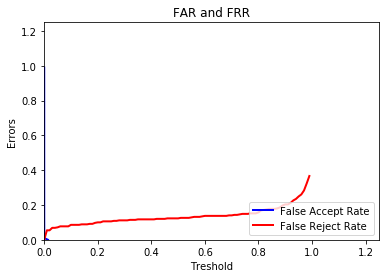

<Figure size 432x288 with 0 Axes>

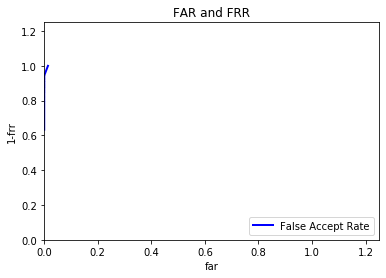

<Figure size 432x288 with 0 Axes>

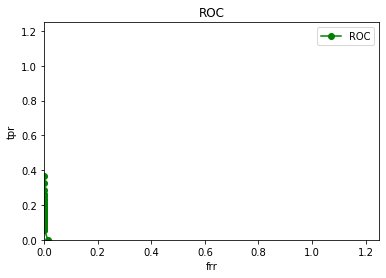

In [3]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc
from scipy import interpolate
from scipy.optimize import brentq

%matplotlib inline 
dataset_dir = "./DE_dataset/"

with open(dataset_dir + "data_orign1.pkl", "rb") as fp:
    cnn_datasets = pickle.load(fp)
with open(dataset_dir + "label_orign1.pkl", "rb") as fp:
    labels = pickle.load(fp)

print(cnn_datasets.shape)
X = cnn_datasets.reshape(-1, 1000, 62)
Y = labels
Y = keras.utils.to_categorical(Y, num_classes=15)
print("Y.shape", Y.shape)

fpr_cf = []
tpr_cf = []
threshold_roc_cf = []
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)


fold = 10
for curr_fold in range(0, fold):
    print("folder: ", curr_fold)
    fold_size = X.shape[0]//fold
    indexes_list = [i for i in range(len(X))]
    indexes = np.array(indexes_list)
    split_list = [i for i in range(curr_fold*fold_size, (curr_fold+1)*fold_size)]
    split = np.array(split_list)
#     print("split", split)
    cnn_test_x = X[split]
    test_y = Y[split]
    split = np.array(list(set(indexes_list)^set(split_list)))
    cnn_train_x = X[split]
    train_y = Y[split]
    train_sample = train_y.shape[0]

    # shuffle data
    index = np.array(range(0, len(train_y)))
    np.random.shuffle(index)

    cnn_train_x = cnn_train_x[index]
    train_y = train_y[index]

    print("training examples:", train_sample)
    test_sample = test_y.shape[0]
    print("test examples    :", test_sample)
    accuracy_all = []
    loss_all = []
      
    histroy = model.fit(cnn_train_x, train_y, batch_size = 200, epochs=100)
    loss, accuracy = model.evaluate(cnn_test_x, test_y, batch_size=200)
#     accuracy_all.append(accuracy)
#     loss_all.append(loss)
    print("accuracy", accuracy)
    print("loss", loss)
    
    curr_fold = str(curr_fold)
    
           
    file_path = "./result/"+ curr_fold + ".xlsx"
    print("saving ", file_path)
    accuracy = pd.DataFrame({"accuracy_all":accuracy_all})
    loss = pd.DataFrame({"loss_all":loss_all})
    
    writer = pd.ExcelWriter(file_path)    
    accuracy.to_excel(writer, 'accuracy_all', index=False)
    loss.to_excel(writer, 'loss', index=False)
    writer.save()

    probas = model.predict(cnn_test_x)
#     fpr, tpr, thresholds = roc_curve(test_y, probas)
#     fpr_cf.append(fpr)
#     tpr_cf.append(tpr)
#     threshold_roc_cf.append(thresholds)    
    
    print("Computing FAR and FRR for graph")
    # t0 = time() 
    y_score = test_posi = probas
    n_classes = cnn_test_x.shape[1]
    test_size = len(y_score)
    total_comparisions = test_size * n_classes
    test_true = test_y
    far, frr = prepare_graph_far_frr(test_true, y_score, total_comparisions - test_size, test_size)
    print(far)
    print(frr)
#     print("done in %0.3fs" % (time() - t0))
    root = brentq( lambda x: x - interpolate.interp1d(far, frr)(x), min(far),max(far))
    print('root', root)    
    print("Plotting graphs...")
    
    plot_far_frr(far, frr, curr_fold)
    plot_far_frr2(far, frr, curr_fold)   # Plot FAR and FRR
    

    plt.figure()
    plt.plot(far, frr, color = 'green', marker = 'o',label = 'ROC')
    plt.legend()
    plt.xlim([0,1.25])
    plt.ylim([0,1.25])
    plt.xlabel('frr')
    plt.ylabel('tpr')
    plt.title('ROC')
    plt.show()

    
